# Azted G-dDT Single Custom Run

## Content

This custom run notebook consists of:
* A custom single run
* A custom Parameter Selection under Uncertainty Run 

Both are primarily useful to explore the model, its dynamics, the effects of different parameter choices, as well as the analysis type itself. 

## Requirements
First, make sure the requirements are installed. 

In [1]:
import seaborn as sns
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import sys
sys.path.append('../')

from IPython.core.getipython import get_ipython

pio.renderers.default = "png"

For individual custom runs, the following parameters can currently be adjusted through custom run arguments.
You can check them out further in params.py, under 'SINGLE_RUN_PARAMS'.
Similarly, you can adjust any other parameters in params.py directly, such as the median for the L1 gas price series or different shock values.
However, the below list can be adjusted directly through arguments in the custom_run function.  

## Simulation Params
* uncle_count (e.g. = 0) # Currently not used, but could be adapted to pay out rewards to the next x highest scores by sequencer proposals (or to use them as backup for later phases)
* fee_subsidy_fraction (e.g. = 1.0)  # Currently not used, but could be adapted to pay out L1 gas fee or L1 blob gas fee cashbacks
* minimum_stake (e.g. = 30) # When Sequencers fall under the minimum stake after a slashing, they will attempt to top-up from their balance. If they do not have enough balance, they are from now on inactive. When running simulations with few agents, and low balances, sometimes blocks get skipped a lot due to a limited active sequencer set
* l1_blocks_per_day (e.g. = int(24 * 60 * 60 / 12.08)) # Type: Int # Conversion to distribute a daily block reward over all L2 blocks
* daily_block_reward (e.g. = 32) # In ETH, lets us vary the total daily block reward (so that different inflation assumptions can be adjusted)

## Phase Durations
* phase_duration_proposal_min_blocks (e.g. = 0) # Measured in L1 blocks. The PSuU instead runs use a Lower Bound per Upper Bound definition to create fixed / dynamical phases.
* phase_duration_proposal_max_blocks (e.g. = 10)  
* phase_duration_reveal_min_blocks (e.g. = 0)  
* phase_duration_reveal_max_blocks (e.g. = 10) 
* phase_duration_commit_bond_min_blocks (e.g. = 0)  
* phase_duration_commit_bond_max_blocks (e.g. = 10) 
* phase_duration_rollup_min_blocks (e.g. = 0)
* phase_duration_rollup_max_blocks (e.g. = 30)  
* phase_duration_race_min_blocks (e.g. = 0)
* phase_duration_race_max_blocks (e.g. = 30) 

## Stake durations
* stake_activation_period (e.g. = 40)   # Not extremely relevant right now, but could be used to have agents drop in / out of the active set
* unstake_cooldown_period (e.g. = 40)

## Behavioral Parameters
* final_probability (e.g. = .99) # Absent detailed assumptions on behavioral aspects of agents, we use a cumulative probability approaching 1 for the willingness test (which means we do not assume many malicious agents or technical failures)
* gas_threshold_for_tx (e.g. = 220)  # Sets the censorship threshold for L1 gas prices, after which agents are prohibited from making L1 transactions
* blob_gas_threshold_for_tx (e.g. = 220) # Sets the censorship threshold for L1 blob gas prices, after which agents are prohibited from making L1 transactions
* proving_marketplace_usage_probability (e.g. = .3) # Lets us vary the likelihood of sequencers choosing to use a 3rd party proving marketplace, versus self-proving
* rewards_to_provers (e.g. = .3)  # Share of total rewards going to the prover UUID 
* rewards_to_relay (e.g. = .01) # Share of total rewards going to the relay UUID 
* gwei_to_tokens (e.g. =1e-9) # Conversion of gwei to tokens. Currently, tokens are set to ETH. By setting the conversion factor (and adjusting absolute values of rewards) we could switch to native tokens.
* gas_estimators=DEFAULT_DETERMINISTIC_GAS_ESTIMATOR, # Defines from where to pull gas prices for L1 transactions 
* tx_estimators=DEFAULT_DETERMINISTIC_TX_ESTIMATOR, # Defines from where to pull transaction estimates for L2 blocks / proposals
* slash_params=SLASH_PARAMS, # Defines the sequencer slashing parameters
* gas_fee_l1_time_series=GAS_FEE_L1_TIME_SERIES_LIST[-1], # Defines the gas price time series
* gas_fee_blob_time_series=GAS_FEE_BLOB_TIME_SERIES_LIST[-1], # Defines the blob gas price time series
* commit_bond_amount (e.g. = 10.0)  # Defines the commitment bond amount
* op_cost_sequencer (e.g. = 1),  # (In Tokens aka ETH) Defines the sequencer operational cost amount that is currently used as a constant to evaluate profitability. Will likely be split into more granular cost assumptions
* op_cost_prover (e.g. = 1) # (In Tokens aka ETH) Defines the prover operational cost amount that is currently used as a constant to evaluate profitability. Will likely be split into more granular cost assumptions
* safety_factor_commit_bond (e.g. = 0.0) # To evaluate profitability based on a profit assumption, the safety factor defines the per_phase multiplier for the occuring gas (and blobgas) fees. A 1.0x would mean that the agent expects rewards > op_cost + fees + (1x fees)
* safety_factor_reveal_content (e.g. = 0.0)
* safety_factor_rollup_proof (e.g. = 0.0)
* past_gas_weight_fraction (e.g. = 0.9) # Smoothens the gas and blob gas time series, by bounding the change between two L1 block's gas prices



In [2]:
import pandas as pd

from aztec_gddt.experiment import custom_run
from aztec_gddt.params import *
from aztec_gddt.types import *

# Params_to_modify consists of a dictionary with certain parameter choices.
# They can be changed for each run through the following argument. 
system_params = {
                    'gas_threshold_for_tx': [200], 
                    'blob_gas_threshold_for_tx': [210], 
                    'daily_block_reward': [32], 
                    'final_probability': [0.95], 
                    'commit_bond_amount': [3],
                    'phase_duration_proposal_min_blocks': [0],
                    'phase_duration_proposal_max_blocks': [10, 20],
                    'phase_duration_reveal_min_blocks': [0],
                    'phase_duration_reveal_max_blocks': [10,20],
                    'phase_duration_commit_bond_min_blocks': [0],
                    'phase_duration_commit_bond_max_blocks': [10],
                    'phase_duration_rollup_min_blocks': [0],
                    'phase_duration_rollup_max_blocks': [30],
                    'phase_duration_rollup_min_blocks': [0],
                    'phase_duration_race_max_blocks': [30]
                    }

# N_timesteps lets us vary the simulation timesteps we want to run
# NOTE: Curently the N_timesteps should be less than or equal to 1000, since 
# certain hard-coded construcdtions depend on this. 
N_timesteps = 1000

# N_samples defines the number of simulation runs we want
N_samples = 3


c:\Users\andre\Desktop\aztec-gddt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
# Read the data. 

FILENAME = "../data/openethdata_eth_data.parquet__1_.gzip"
data_to_use = pd.read_parquet(FILENAME) 

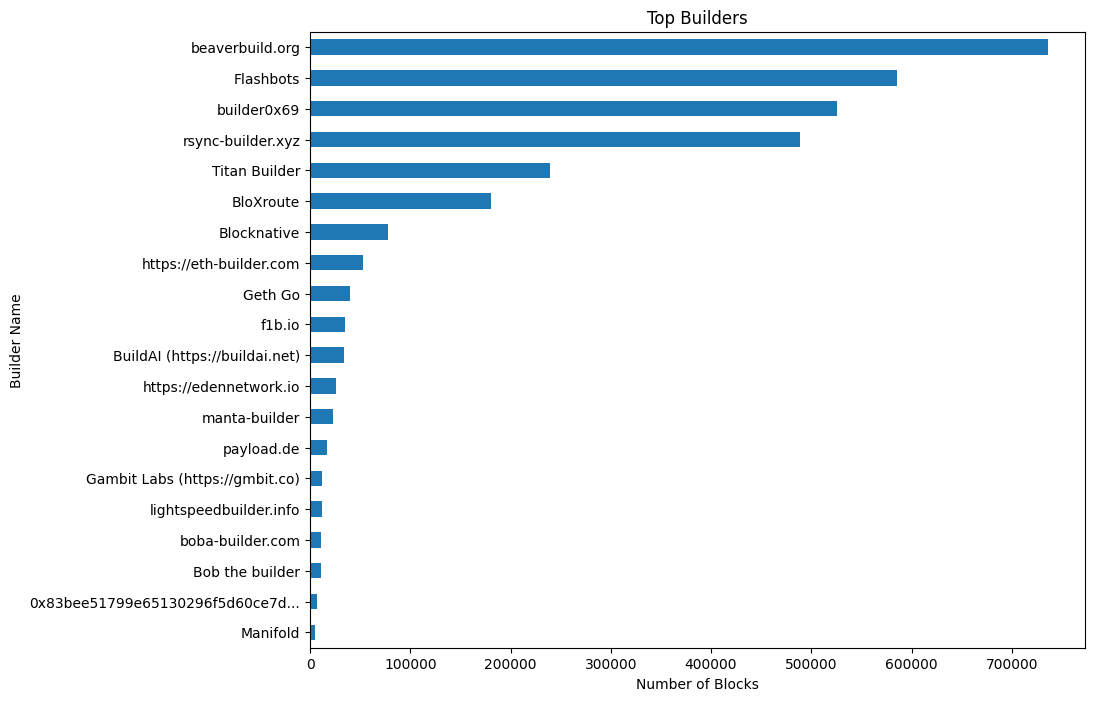

In [4]:
# Plot for top builders

# Number of top entries you want to display
N = 20

# Calculating the count of each unique value
counts = data_to_use['builder'].value_counts()

# Selecting the top N entries
top_n = counts.nlargest(N)

# Creating a horizontal bar plot
plt.figure(figsize=(10, 8))
top_n.plot(kind='barh')

labels = [label[:30] + '...'
         if len(label) > 30 
         else label 
         for label in top_n.index]

plt.xlabel('Number of Blocks')
plt.ylabel('Builder Name')
plt.yticks(ticks = range(N), labels=labels)
plt.title('Top Builders')
plt.gca().invert_yaxis()  # To display the largest at the top
plt.show()

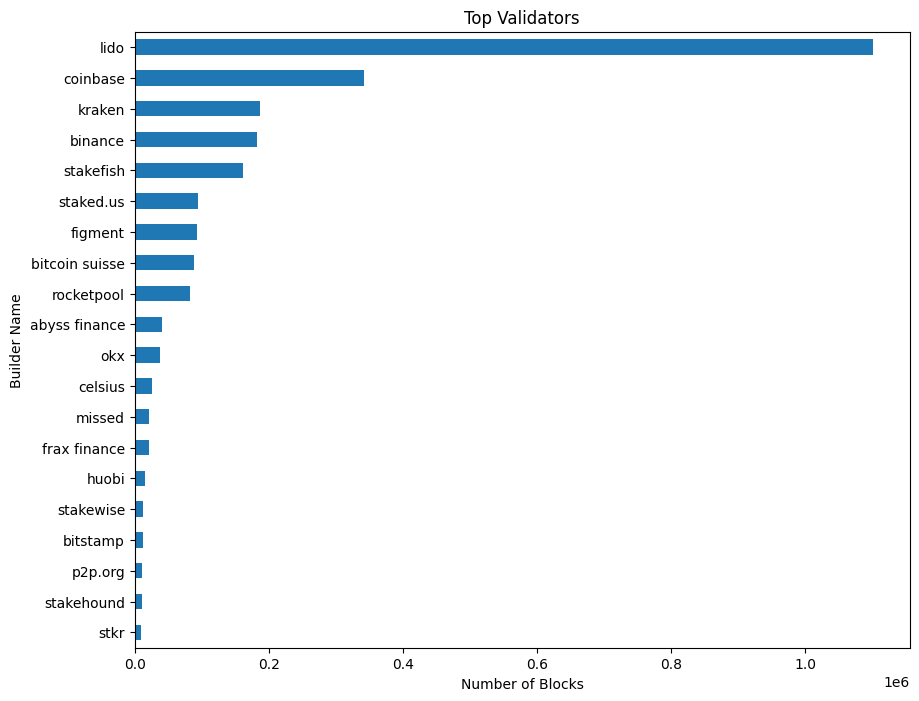

In [5]:
# Plot for top validators

# Number of top entries you want to display
N = 20

# Calculating the count of each unique value
counts = data_to_use['validator'].value_counts()

# Selecting the top N entries
top_n = counts.nlargest(N)

# Creating a horizontal bar plot
plt.figure(figsize=(10, 8))
top_n.plot(kind='barh')

labels = [label[:30] + '...'
         if len(label) > 30 
         else label 
         for label in top_n.index]

plt.xlabel('Number of Blocks')
plt.ylabel('Builder Name')
plt.yticks(ticks = range(N), labels=labels)
plt.title('Top Validators')
plt.gca().invert_yaxis()  # To display the largest at the top
plt.show()

In [6]:
# USER INPUT: Censorship information
# Add here the lists of censoring builders and validators. 
# Leave empty for no censorship.

censoring_builders = ['Flashbots']
censoring_validators = ['abyss_finance']

In [7]:
# Build censoring params
censorship_params = build_censor_params(data = data_to_use, 
                        censoring_builders = censoring_builders,
                        censoring_validators = censoring_validators,
                        start_time = 0)

In [8]:
# Combine censorship params with structural params

params_to_modify = {**system_params, **censorship_params} 

In [9]:

#sim_df saves the run to a dataframe, from which we can plot any state measurements or metrics
sim_df = custom_run(N_timesteps=N_timesteps,
                    N_samples=N_samples,
                    params_to_modify=params_to_modify)

Initializing configurations: 100%|██████████| 6/6 [00:00<00:00, 94.51it/s]


KeyError: 1001

In [ ]:
sim_df['phase_duration_proposal_max_blocks'].unique()

In [ ]:
interesting_cols = [param_name 
                    for param_name, param_val
                    in params_to_modify.items() 
                    if len(param_val) > 1]
interesting_cols

# Create new cells for each element in the list

metric_col_name = 'finalized_blocks_count'
param_col_name = 'phase_duration_proposal_max_blocks'

# HACK: Use the `run_cell` command to generate multiple plots. 

for col in interesting_cols:
    cmd = f"""
           metric_col_name = 'finalized_blocks_count'
           param_col_name = '{col}'

           sns.lineplot(x=sim_df.time_l1, 
                        y=sim_df[metric_col_name],
                        hue = sim_df[param_col_name])
           plt.title(f"{param_col_name} vs. {metric_col_name}")
          """
    get_ipython().run_cell(cmd)

In [ ]:
sim_df['phase_duration_proposal_max_blocks'].unique()

In [ ]:
# How many blocks were we able to finalize per simulated L1 block? 
metric_col_name = 'finalized_blocks_count'
param_col_name = 'phase_duration_proposal_max_blocks'

sns.lineplot(x=sim_df.time_l1, 
             y=sim_df[metric_col_name],
             hue = sim_df[param_col_name])
plt.title(f"{param_col_name} vs. {metric_col_name}")

In [ ]:
# This is a simple graph letting us check the gas and blob gas fees over the simulation run, as well as the censorship thresholds defining when no L1 transactions at all can be made. 
px.line(sim_df,
           x='time_l1',
        y=['gas_fee_l1', 'gas_fee_blob', 'gas_threshold_for_tx', 'blob_gas_threshold_for_tx'])

In [ ]:
# Let's grab the final row of our state measurements and examine. 
sim_df.iloc[-1]

In [ ]:
# Following visualization allows us to examine the transition through phases, until a block is either finalized or skipped.
fig_df = sim_df.copy()
fig_df['process_order'] = fig_df.current_process.map(
    lambda x: x.phase.value if x is not None else None)
fig_df['process_label'] = fig_df.current_process.map(
    lambda x: x.phase.name if x is not None else None)
# .query("time_l1 > 320 & time_l1 < 370")
fig_df = fig_df.sort_values(['process_order', 'timestep'])


plt.figure(figsize=(15, 5))
sns.lineplot(x=fig_df.time_l1,
             y=fig_df.process_label)

plt.figure(figsize=(15, 5))
sns.scatterplot(x=fig_df.time_l1,
                y=fig_df.process_label)
plt.show()

In [ ]:
# As seen before, while we defined 1000 simulation timestep, due to some efficiency measures, we are simulating more L1 blocks than we have simulation timesteps
# Time_l1 are the L1 blocks (12sec), while timestep gives us the simulation steps
sns.lineplot(x=sim_df.timestep, y=sim_df.time_l1)

In [ ]:
# Lets grab all rows except for the final one and decide what to look for 
sim_df.head(-1)

In [ ]:
# How many blocks were we able to finalize per simulated L1 block? 
metric_col_name = 'finalized_blocks_count'
param_col_name = 'phase_duration_proposal_max_blocks'

sns.lineplot(x=sim_df.time_l1, 
             y=sim_df[metric_col_name],
             hue = sim_df[param_col_name])
plt.title(f"{param_col_name} vs. {metric_col_name}")

In [ ]:
# For cumulative block rewards, note that we are not cold-starting the experiments.
# Starting from 200 initial cumulative rewards, we go up whenever a block is successfully finalized. 
metric_col_name = 'cumm_block_rewards'
param_col_name = 'phase_duration_proposal_max_blocks'

sns.lineplot(data = sim_df,
             x='time_l1', 
             y=metric_col_name,
             hue = param_col_name)

plt.title(f"{param_col_name} vs. {metric_col_name}")

In [ ]:
# The token supply is calculated from specific holdings of agents.
# When a Sequencer gets slashed, but has enough balance to top up, they will transfer from their balance to their stake. 
ts_df = sim_df.token_supply.apply(lambda x: pd.Series(x.__dict__))
ts_df.plot(kind='line')
plt.title("Token Supply")
plt.show()

In [ ]:
# The token supply is calculated from specific holdings of agents.
# When a Sequencer gets slashed, but has enough balance to top up, they will transfer from their balance to their stake. 
ts_df = sim_df.token_supply.apply(lambda x: pd.Series(x.__dict__)).diff()
ts_df.plot(kind='line')
plt.title("$\Delta$ Token Supply")
plt.show()